## TSPC
### In this model, we first divide data set into 3 clusters, then find the shortest path in any two cities, then fix the cities in sub-chromosomes. We apply crossover and mutate to all sub-chromosomes separately, finally we fix them together to rebulid a normal chromosome.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from sklearn.cluster import KMeans
import pandas as pd
%matplotlib inline

In [2]:
# A simple function to compute distance bewteen two citys.
def CacDistance(a,b):
    
    a = np.array(a)
    b = np.array(b)
    c = a-b
    distance = np.sqrt(np.sum(c*c))
    return distance

# Get the Adjacency Matrix
def CityDistance(locs):
    
    
    n = len(locs)
    dis_mat = np.zeros([n,n])
    for i in range(n-1):
        for j in range(i+1,n):
            dist = CacDistance(locs[i],locs[j])
            dis_mat[i,j] = dist

    for i in range(n):
        dis_mat[:,i] = dis_mat[i,:]

    return dis_mat

In [3]:
# A simple function to compute the cost of a chromosome
def cost(s):
    
    n = len(s)
    cost = 0
    for i in range(n):
        cost += dis[s[i],s[(i+1)%n]]   
    
    return -cost   #return negtive value to set a Minimization problem

# A simple function to get each chromosome's fitness in population
def getfitness(population):
            
    fitness = []
    
    for p in population:
        icost = cost(p)
        fitness.append(icost)
        
    return fitness

In [4]:
# A simple function to get the third element of list
def TakeThird(element):
    return element[2]


# A function get index of chromosome, chromosome's fitness, pobability, and cumulative probability in adaption
def CacAdap(population):
    # Compute every chromosome‘s fitness in population
    
    adaption = []
    psum = 0
    i = 0
    for p in population:
        icost = np.exp(cost(p))
        psum += icost
        adaption.append([i])  #add the index of each chromosome
        adaption[i].append(icost) #add the fitness of each chromosome
        i += 1
    
    # Compute the selection probability
    for p in adaption:
        p.append(p[1]/psum)
        p.append(p[2])
        
    # sort adaption by the fitness of each chromosome
    adaption.sort(key=TakeThird,reverse=True)
    
    # Compute the cumulative probability
    n = len(adaption)
    for i in range(1,n):
        p = adaption[i][3] + adaption[i-1][3]
        adaption[i][3] = p
        
        
    return adaption

In [5]:
def Chose(adaption, population):
    
    #Roulette Whell Selection
    """
    Here we keep the Elite chromosome before selection to prevent some good chromosomes are ignored 
because of Roulette Whell Selection
    """
    best_chromosome = getElite(population)
    
    chose = []
    
    # selection,and get the index of chromosome in population
    epochs = population_init_size 
    n = len(adaption)
    for a in range(epochs):
        p = random.random()
        if adaption[0][3] >= p:
            chose.append(adaption[0][0])
        else:
            for i in range(1,n):
                if adaption[i][3] >= p and adaption[i-1][3] < p:
                    chose.append(adaption[i][0])
                    break
                    
    chose = list((chose))
    
    population_temp = []
    
    for i in chose:
        population_temp.append(population[i])
    
    return population_temp,best_chromosome

In [6]:
# A function of Crossover
# We need to handle the collision

"""
Here is the basic introduction about how to solve the collision
After we exchange two parts of two chromosomes, we can figure out that all collision genes must exist in exchange part
so that we get the list named collision_a and collision_b
Then we fix two parts of genes left in parent chromosome, that is remaining_a and remaining_b
All we need to do is let length of collision list become 0

If there is a collision, we don't change the exchange part, we just change the remaining part.

Now this is a example to show you how we tackle collision problem.

after crossover, we have:
a = [0,1,{4,3,2,1},6]
b = [6,5,{2,3,4,5},0]
so 1 is a collision in a, so we first find the position of 1 in exchange_genes_b({4,3,2,1}), which is 3
then we get the value of the same position in exchange_genes_a({2,3,4,5}), which is 5
then we set '1' in remaining_a to 5, so a becomes:
a = [0,5,{4,3,2,1},6]
so a has no collision now, so then drop the '1' in collision_a.
This method may induce other collision, so the code will recycle until the length of collision_a becomes 0.
"""

def Cross(p1,p2):

    chromosome1 = p1.copy()
    chromosome2 = p2.copy()
    
    index = random.randint(0,2)
    
    
    cluster_chromosome1 = get_cluster_population([chromosome1])[0]
    cluster_chromosome2 = get_cluster_population([chromosome2])[0]
    
    
#     print(cluster_chromosome1)
#     print(cluster_chromosome2)
#     print(index)
    
    a = cluster_chromosome1[index].copy()
    b = cluster_chromosome2[index].copy()
    
#     print(a)
#     print(b)
    
    # randomly generates two number from 0-9, and I ensure that length of begin to end must larger than 1,
    # if begin = n, end = n+1, than this Crossover operation becomes Mutation
    
    
    begin = random.randint(1,len(a)-2)
    end = random.randint(1,len(a)-2)
    while abs(begin - end) <2:
        begin = random.randint(1,len(a)-2)
        end = random.randint(1,len(a)-2)
    # Ensure begin is smaller than end
    if begin > end:
        temp = begin
        begin = end
        end = temp
        
    # get the genes we want to exchange use the slice method of list
    exchange_genes_a = a[begin:end].copy()
    exchange_genes_b = b[begin:end].copy()
    
    collision_a = []
    collision_b = []
    
    # get the collision number in a and b
    for i in exchange_genes_b:
        if i not in exchange_genes_a:
            collision_a.append(i)
            
    for i in exchange_genes_a:
        if i not in exchange_genes_b:
            collision_b.append(i)
            
    # Crossover     
    a[begin:end] = exchange_genes_b
    b[begin:end] = exchange_genes_a
    
#     print('####')
#     print(a)
#     print(b)
    
    
    # Handle the collision
    
    # get the remaining part of a
    remaining_a = a[0:begin] + a[end:]
    while len(collision_a) > 0:
        temp = exchange_genes_a[exchange_genes_b.index(collision_a[-1])]
        remaining_a[remaining_a.index(collision_a[-1])] = temp
        if remaining_a.count(collision_a[-1]) == 0:
            collision_a.pop()
        if temp in exchange_genes_b and temp in remaining_a:
            collision_a.append(temp)
            
    # recover a by remaining_a which is containing no collision
    a[0:begin] = remaining_a[0:begin]
    a[end:] = remaining_a[begin:]
    
    # as the same as a
    remaining_b = b[0:begin] + b[end:]
    while len(collision_b) > 0:
        temp = exchange_genes_b[exchange_genes_a.index(collision_b[-1])]
        remaining_b[remaining_b.index(collision_b[-1])] = temp
        
        if remaining_b.count(collision_b[-1]) == 0:
            collision_b.pop()
        
        if temp in exchange_genes_a and temp in remaining_b:
            collision_b.append(temp)
    
    b[0:begin] = remaining_b[0:begin]
    b[end:] = remaining_b[begin:]
    
    
    cluster_chromosome1[index] = a
    cluster_chromosome1[index] = b

    
    chromosome1 = get_normal_population([cluster_chromosome1])[0]
    chromosome2 = get_normal_population([cluster_chromosome2])[0]

    return chromosome1,chromosome2

In [7]:
# A simple function of Mutation, just swap two genes
def Mutation(s):
    
    cluster_s = get_cluster_population([s])[0]
    
    index = random.randint(0,2)
    
    target_partial_chromosome = cluster_s[index]
    
    
    c = range(1,len(target_partial_chromosome)-1)
    index1,index2 = random.sample(c,2)
    temp = target_partial_chromosome[index1]
    target_partial_chromosome[index1] = target_partial_chromosome[index2]
    target_partial_chromosome[index2] = temp
    
    cluster_s[index] = target_partial_chromosome
    
    normal_s = get_normal_population([cluster_s])[0]
    
    return normal_s

In [8]:
def Crossover_Mutation(population, best_chromosome, current_crossover_rate, current_mutation_rate):
    
    # Compute the number of chromosome we need to crossover and mutation
    number_of_crossover = int(math.ceil(current_crossover_rate * len(population)))
    number_of_mutation = int(math.ceil(current_mutation_rate * len(population)))
    
    # To store the child of crossover and mutation
    temp_chromosome = []
    
    # Crossover operation
    for i in range(number_of_crossover//2):
        index1,index2 = random.sample(range(0,len(population)),2)
        parent1 = population[index1].copy()
        parent2 = population[index2].copy()
        child1,child2 = Cross(parent1,parent2)
        temp_chromosome.append(list(child1))
        temp_chromosome.append(list(child2))
        
    # Mutation operation 
    for i in range(number_of_mutation):
        mutation_index = random.sample(range(0,len(population)),1)
        mutation_parent = population[mutation_index[0]].copy()
        mutation_child = Mutation(mutation_parent)
        temp_chromosome.append(mutation_child)
        
    # Append the child into population
    for i in temp_chromosome:
        population.append(i)
        
        
#     # Append the best chromosome before selection into population
    population = addelite(population,best_chromosome)   


    return population

In [9]:
def addelite(population, best_chromosome):
    
    population_fitness = getfitness(population)
    elite_fitness = getfitness(best_chromosome)
    
    while len(elite_fitness) != 0 and min(population_fitness) < max(elite_fitness) :
        
        index_min_pop = population_fitness.index(min(population_fitness))
        index_max_elite = elite_fitness.index(max(elite_fitness))
        
        population[index_min_pop] = best_chromosome[index_max_elite]
        
        population_fitness[index_min_pop] = 9999999
        elite_fitness.remove(elite_fitness[index_max_elite])
    
    
    return population

In [10]:
# A simple funtion to get Elite chromosome in current population
def getElite(population):
    
    len_elite = int(math.ceil(elite_keep_rate * len(population)))
    if len_elite < 1 :
        len_elite = 1
    
    adaption = getfitness(population)

    best_chromosome = []
    best_chromosome_index = list(np.argsort(adaption)[::-1][:len_elite])

    for i in best_chromosome_index:
        best_chromosome.append(population[i])
        
    return best_chromosome
    

In [11]:
def get_normal_population(population):
    new_population = []
    for i in range(len(population)):
        new_population.append([])


    for i in range(len(population)):
        for j in population[i]:
            for k in j:
                new_population[i].append(k)
    
                
    return new_population

In [12]:
def get_cluster_population(normal_poplation):
    
    cluster_population = []
    
    for i in range(len(normal_poplation)):
        cluster_population.append([])
        
        
    for i in range(len(cluster_population)):
        
        cluster_population[i].append(normal_poplation[i][0:number_cluster_0])
        cluster_population[i].append(normal_poplation[i][number_cluster_0:number_cluster_1+number_cluster_0])
        cluster_population[i].append(normal_poplation[i][number_cluster_1+number_cluster_0:])
        
#     print('999999') 
#     print(cluster_population)
    
    return cluster_population
        

In [19]:
def GA(normal_population, current_crossover_rate, current_mutation_rate):
    
        
#     normal_population = get_normal_population(population)
    

    # get the adaption
    adaption = CacAdap(normal_population)
    
    # choose chromosome base on Roulette Whell Selection
    normal_population, best_chromosome = Chose(adaption, normal_population)
    
    # Crossover and Mutation in population
    normal_population = Crossover_Mutation(normal_population, best_chromosome, current_crossover_rate, current_mutation_rate)



    return normal_population

In [14]:
def find_min(population, iteration):
    loss = []
    i = 0
    j = 0
    
    normal_population = get_normal_population(population)
    current_crossover_rate = crossover_rate
    current_mutation_rate = mutation_rate
    current_best_fitness = max(getfitness(normal_population))
    
    # begin iteration
    while i < iteration:
        
        
        fitness = getfitness(normal_population)
        min_cost = max(fitness)
        
        if current_best_fitness == min_cost:
            j = j + 1
        else:
            current_best_fitness = min_cost
            current_crossover_rate = crossover_rate
            current_mutation_rate = mutation_rate
            j = 0
        
        if j==5:
            if current_crossover_rate + 0.05 < 1 :
                current_crossover_rate += 0.05
        if j==10:
            if current_crossover_rate + 0.05 < 1 :
                current_crossover_rate += 0.05
            if current_mutation_rate + 0.05 < 1:
                current_mutation_rate += 0.05
            j=0
            
        normal_population = GA(normal_population, current_crossover_rate, current_mutation_rate)
                
        if i%10 == 0:
            print('iteration %d: loss=%.2f'%(i,-min_cost))
        loss.append([i,-min_cost])
        i += 1
        
        #print the best result
        if i == iteration:
                        
            p_len = len(normal_population)
            for index in range(p_len):
                if fitness[index] == min_cost:
                    print('Optimal path:')
                    print(normal_population[index])
                    Optimal_Path_Cluster = get_cluster_population([normal_population[index]])[0]
                    print('Optimal Path by Cluster')
                    print(Optimal_Path_Cluster)
                    print('Optimal cost:')
                    print(-min_cost)
                    break
    # print the plot of how the cost function goes
    loss = np.array(loss)
    plt.plot(loss[:,0],loss[:,1])
    plt.title('TSPC')
    plt.savefig('TSPC.png', dpi= 600)
    plt.show()

In [15]:
def Divide_City(TSP_df):
    City = []
    for i in range(len(TSP_df)):
        City.append((TSP_df['X'][i], TSP_df['Y'][i]))
    
    clf = KMeans(n_clusters=3, random_state=1)
    clf.fit(City)

    label = clf.labels_

    Cluster_0 = []
    Cluster_1 = []
    Cluster_2 = []

    City_location = TSP_df[['X','Y']]
    City_location = round((City_location-City_location.min())/(City_location.max()-City_location.min()), 4)

    locs = []
    for i in range(len(City_location)):
        locs.append((City_location['X'][i],City_location['Y'][i]))
 

    j=0
    for i in label:
        if i == 0:
            Cluster_0.append((locs[j],j))
        elif i == 1:
            Cluster_1.append((locs[j],j))
        else:
            Cluster_2.append((locs[j],j))
        j+= 1
        
    return Cluster_0, Cluster_1, Cluster_2

def get_nearest(locs, Cluster_0, Cluster_1, Cluster_2):
    Min = 9999
    for i in Cluster_0:
        for j in Cluster_1:
            dis = (i[0][0] - j[0][0])**2 + (i[0][1] - j[0][1])**2
            if Min > dis:
                Min = dis
                C_0_1_0 = i
                C_0_1_1 = j
    Min = 9999
    for i in Cluster_1:
        for j in Cluster_2:
            dis = (i[0][0] - j[0][0])**2 + (i[0][1] - j[0][1])**2
            if Min > dis:
                Min = dis
                C_1_2_1 = i
                C_1_2_2 = j
    Min = 9999           
    for i in Cluster_2:
        for j in Cluster_0:
            dis = (i[0][0] - j[0][0])**2 + (i[0][1] - j[0][1])**2
            if Min > dis:
                Min = dis
                C_2_0_2 = i
                C_2_0_0 = j
                
                
    return C_0_1_0[1],C_0_1_1[1],C_1_2_1[1],C_1_2_2[1],C_2_0_2[1],C_2_0_0[1]

In [16]:
def get_City_Cluster(Cluster_0, Cluster_1, Cluster_2):
    City_Cluster_0 = []
    City_Cluster_1 = []
    City_Cluster_2 = []
#     print(Cluster_0)
    
    for i in Cluster_0:
#         print(i)
        City_Cluster_0.append(i[1])    
    for i in Cluster_1:
        City_Cluster_1.append(i[1])
    for i in Cluster_2:
        City_Cluster_2.append(i[1])
        
#     print('####')
#     print(City_Cluster_0)
        
        
    return City_Cluster_0, City_Cluster_1, City_Cluster_2

In [17]:
def get_population():
    population = []
    for i in range(0,population_init_size):
        population.append([])
    #     print(len(population))
        population[i].append(City_Cluster_0)
        population[i].append(City_Cluster_1)
        population[i].append(City_Cluster_2)


    for i in range(len(population)):
        for j in range(3):
            temp = population[i][j].copy()
            random.shuffle(temp)
            population[i][j] = temp


    for i in range(len(population)):

        population[i][0].insert(0,C_2_0_in_zero)
        population[i][0].insert(len(population[i][0]),C_0_1_in_zero)

        population[i][1].insert(0,C_0_1_in_one)
        population[i][1].insert(len(population[i][1]),C_1_2_in_one)

        population[i][2].insert(0,C_1_2_in_two)
        population[i][2].insert(len(population[i][2]),C_2_0_in_two)
        
    return population

37 36 5 4 23 41
iteration 0: loss=11.76
iteration 10: loss=9.53
iteration 20: loss=8.36
iteration 30: loss=7.79
iteration 40: loss=7.64
iteration 50: loss=7.48
iteration 60: loss=7.31
iteration 70: loss=7.17
iteration 80: loss=7.15
iteration 90: loss=7.10
iteration 100: loss=7.09
iteration 110: loss=7.09
iteration 120: loss=7.00
iteration 130: loss=6.95
iteration 140: loss=6.93
iteration 150: loss=6.93
iteration 160: loss=6.89
iteration 170: loss=6.89
iteration 180: loss=6.89
iteration 190: loss=6.87
iteration 200: loss=6.87
iteration 210: loss=6.87
iteration 220: loss=6.87
iteration 230: loss=6.87
iteration 240: loss=6.87
iteration 250: loss=6.87
iteration 260: loss=6.87
iteration 270: loss=6.87
iteration 280: loss=6.87
iteration 290: loss=6.87
iteration 300: loss=6.87
iteration 310: loss=6.87
iteration 320: loss=6.87
iteration 330: loss=6.87
iteration 340: loss=6.84
iteration 350: loss=6.84
iteration 360: loss=6.84
iteration 370: loss=6.84
iteration 380: loss=6.84
iteration 390: loss

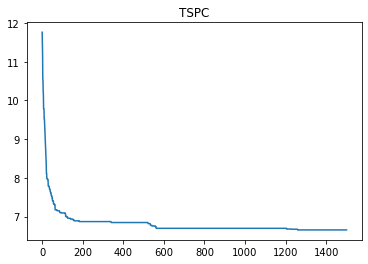

In [37]:
# HyperParameters
city_number = 50
population_init_size = 200  #the population size
elite_keep_rate = 0.15      #define how much elite will be kept
iteration_times = 1501       #times of iteration
crossover_rate = 0.8        #rate of crossover
mutation_rate = 0.15        #rate of mutation


TSP_df = pd.read_csv('/Users/singlexu/Desktop/Artificial Intelligence Concepts/Project 1/Dataset/Cluster_dataset.csv')

City_location = TSP_df[['X','Y']]
City_location = round((City_location-City_location.min())/(City_location.max()-City_location.min()), 4)

locs = []
for i in range(len(City_location)):
    locs.append((City_location['X'][i],City_location['Y'][i]))
    
Cluster_0, Cluster_1, Cluster_2 = Divide_City(TSP_df)

# print(len(Cluster_0),len(Cluster_1),len(Cluster_2))


C_0_1_in_zero,C_0_1_in_one, C_1_2_in_one,C_1_2_in_two,C_2_0_in_two,C_2_0_in_zero = get_nearest(locs,Cluster_0, Cluster_1, Cluster_2)


print(C_0_1_in_zero,C_0_1_in_one, C_1_2_in_one,C_1_2_in_two,C_2_0_in_two,C_2_0_in_zero)

City_Cluster_0, City_Cluster_1, City_Cluster_2 = get_City_Cluster(Cluster_0, Cluster_1, Cluster_2)

number_cluster_0 = len(City_Cluster_0)
number_cluster_1 = len(City_Cluster_1)
number_cluster_2 = len(City_Cluster_2)

# print(number_cluster_0,number_cluster_1,number_cluster_2)

City_Cluster_0.remove(C_0_1_in_zero)
City_Cluster_0.remove(C_2_0_in_zero)

City_Cluster_1.remove(C_1_2_in_one)
City_Cluster_1.remove(C_0_1_in_one)

City_Cluster_2.remove(C_2_0_in_two)
City_Cluster_2.remove(C_1_2_in_two)



# randomly generates population
population = get_population()


# print(len(population))
# get the Adjacency Matrix of the citys
dis = CityDistance(locs)

# # main function 
find_min(population, iteration_times)